In [1]:
blinded_fit = True
plot_obs = True
plot_exp = True

version_Combination = 'v2'
version_singleCard = 'v13'

# Import

In [2]:
import sys, os
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import commands

In [3]:
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [4]:
from combine_utilities import getUncertaintyFromLimitTree

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if plot_obs:
    CMS_lumi.extraText = "    Preliminary"
else:
    CMS_lumi.extraText = "    Simulation Preliminary"

expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4} #fb^-1
CMS_lumi.integrated_lumi = expectedLumi['high']

# Load results

In [5]:
resObs = {}
for cat in ['low', 'mid', 'high', 'comb']:
    resObs[cat] = None
    if not plot_obs: 
        continue
    
    scanLoc = 'results/'
    if cat=='comb':
        scanLoc += version_Combination+'combination'
    else:
        scanLoc += version_singleCard+cat
    if blinded_fit:
        scanLoc += '_blinded'
    scanLoc += '/higgsCombine*_nominal.MultiDimFit.mH120.root'
    scanLoc = glob(scanLoc)
    if not len(scanLoc):
        print cat, 'not found'
        continue
    print cat
    resObs[cat] = getUncertaintyFromLimitTree(scanLoc[0])

low
----------------------------------
R(D*) = 0.688 +0.116/-0.114 [16.7 %]
Sigma = 0.115
----------------------------------

mid
----------------------------------
R(D*) = 0.718 +0.107/-0.106 [14.8 %]
Sigma = 0.107
----------------------------------

high
----------------------------------
R(D*) = 0.865 +0.127/-0.124 [14.5 %]
Sigma = 0.126
----------------------------------

comb
----------------------------------
R(D*) = 0.728 +0.080/-0.081 [11.0 %]
Sigma = 0.080
----------------------------------



In [6]:
resExp = {}
for cat in ['low', 'mid', 'high', 'comb']:
    resExp[cat] = None
    if not plot_exp: 
        continue
    
    scanLoc = 'results/'
    if cat=='comb':
        scanLoc += version_Combination+'combination'
    else:
        scanLoc += version_singleCard+cat
    scanLoc += '_Asimov'
    if blinded_fit:
        scanLoc += '_blinded'
    scanLoc += '/higgsCombine*_nominal.MultiDimFit.mH120.root'
    scanLoc = glob(scanLoc)
    if not len(scanLoc):
        print cat, 'not found'
        continue
    print cat
    resExp[cat] = getUncertaintyFromLimitTree(scanLoc[0])

low
----------------------------------
R(D*) = 0.302 +0.117/-0.115 [38.3 %]
Sigma = 0.116
----------------------------------

mid
----------------------------------
R(D*) = 0.300 +0.106/-0.105 [35.2 %]
Sigma = 0.106
----------------------------------

high
----------------------------------
R(D*) = 0.299 +0.123/-0.121 [40.7 %]
Sigma = 0.122
----------------------------------

comb
----------------------------------
R(D*) = 0.300 +0.076/-0.075 [25.0 %]
Sigma = 0.075
----------------------------------



# Create plot

In [7]:
cOut = rt.TCanvas('cOut', 'cOut', 50, 50, 1200, 600)
grAux = rt.TGraph()
grAux.SetPoint(0, 0, 0)
grAux.SetPoint(1, 1, 1)
grAux.Draw('AP')

In [8]:
box = rt.TPave()
box.SetLineWidth(0)
box.SetFillStyle(1001)
box.SetBorderSize(0)
boxColors = [rt.kGreen+1, rt.kOrange]
boxHeight = 0.15

text = rt.TLatex()
text.SetTextAlign(12)
text.SetTextSize(0.04)
text.SetTextFont(42)
textColors = [1,rt.kRed-4]
textPosX = 1.2 if blinded_fit else 0.5

leg = rt.TLegend(0.78, 0.5, 0.98, 0.8)
leg.SetBorderSize(0)

In [9]:
ypos = -1
ylabels = {}

pointObs = rt.TGraph()
pointExp = rt.TGraph()

lastDrawnIsComb = False

for cat in ['comb', 'low', 'mid', 'high']:
    aux = int(resExp[cat] is None) + int(resObs[cat] is None)
    displ = 0.07 + 0.5*boxHeight if aux == 0 else 0

    if aux < 2:
        ypos += 1
        if lastDrawnIsComb:
            ypos += 1
        if cat == 'comb': 
            ylabels[ypos] = 'Combined'
            lastDrawnIsComb = True
        else:
            ylabels[ypos] = cat.capitalize()
            lastDrawnIsComb = False
            
        for i, res in enumerate([resObs[cat], resExp[cat]]):
            if res is None:
                continue

            if i == 0:
                yAux = ypos + displ
                pointObs.SetPoint(pointObs.GetN(), res[0], yAux)
                box.SetFillStyle(1001)
            else:
                yAux = ypos - displ
                pointExp.SetPoint(pointExp.GetN(), res[0], yAux)
                box.SetFillStyle(3001)
            
            box.SetFillColor(boxColors[-1])
            b2 = box.DrawBox(float(res[-4]), yAux - 0.5*boxHeight, float(res[-1]), yAux + 0.5*boxHeight)
            box.SetFillColor(boxColors[-2])
            b1 = box.DrawBox(float(res[-3]), yAux - 0.5*boxHeight, float(res[-2]), yAux + 0.5*boxHeight)

            text.SetTextColor(textColors[i])
            l = text.DrawLatex(textPosX, yAux, '{:.3f} #pm {:.3f}'.format(res[0], res[3]))

In [10]:
l = rt.TLine()
l.SetLineStyle(9)
l.SetLineWidth(2)
box.SetFillStyle(1001)

RDst_Th = 0.258
box.SetFillColorAlpha(rt.kViolet-7, 0.5)
box.DrawBox(RDst_Th - 0.005, -1, RDst_Th + 0.005, ypos+1)
l.SetLineColor(rt.kViolet-7)
l.DrawLine(RDst_Th, -1, RDst_Th, ypos+1)
leg.AddEntry(l, 'SM prediction', 'l')

RDst_avg = 0.295
box.SetFillColorAlpha(rt.kAzure+1, 0.5)
box.DrawBox(RDst_avg - 0.014, -1, RDst_avg + 0.014, ypos+1)
l2 = l.Clone('l2')
l2.SetLineColor(rt.kAzure+1)
l2.DrawLine(RDst_avg, -1, RDst_avg, ypos+1)
leg.AddEntry(l2, 'Experimental Avg.', 'l')

<ROOT.TLegendEntry object ("TLegendEntry") at 0xa690b20>

In [11]:
pointObs.SetMarkerStyle(20)
pointObs.SetMarkerColor(textColors[0])
if pointObs.GetN(): 
    pointObs.Draw('P') 
    leg.AddEntry(pointObs, 'Observed', 'p')

pointExp.SetMarkerStyle(33)
pointExp.SetMarkerSize(1.5)
pointExp.SetMarkerColor(textColors[1])
if pointExp.GetN(): 
    pointExp.Draw('P') 
    leg.AddEntry(pointExp, 'Expected', 'p')

In [12]:
xMax = 2 if blinded_fit else 1.
grAux.GetXaxis().SetLimits(0, xMax)
grAux.GetXaxis().SetTitle('R(D*)')
grAux.GetHistogram().SetMinimum(-1)
grAux.GetHistogram().SetMaximum(ypos+1)

ax = grAux.GetYaxis()
ax.SetNdivisions(-(ypos+2))
ax.ChangeLabel()
for i in range(1, ypos+4):
    if i-2 in ylabels.keys():
        ax.ChangeLabel(i, -1, -1, -1, -1, -1, ylabels[i-2])
    else:
        ax.ChangeLabel(i, -1, -1, -1, -1, -1, ' ')
ax.SetTickLength(0.0)

In [13]:
box.SetFillColor(boxColors[0])
leg.AddEntry(box, '#pm 1#sigma band', 'f')
box2 = box.Clone('box2')
box2.SetFillColor(boxColors[1])
leg.AddEntry(box2, '#pm 2#sigma band', 'f')

leg.Draw()

In [14]:
text.SetTextAlign(32)
text.SetTextColor(1)
text.SetTextSize(0.06)
if blinded_fit:
    text.DrawLatex(0.975*xMax, ypos+0.6, 'Blinded fit results')
else:
    text.DrawLatex(0.975*xMax, ypos+0.6, 'Fit results')

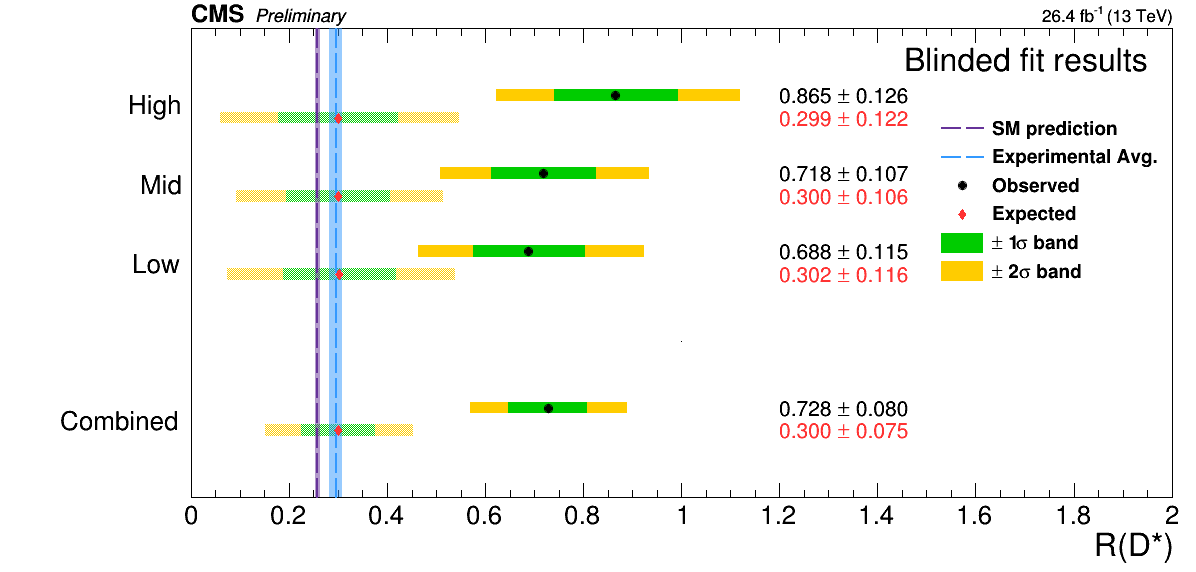

In [15]:
CMS_lumi.CMS_lumi(cOut, -1, 0, cmsTextSize=0.9, lumiTextSize=0.75)
cOut.Draw()